In [ ]:
import torchvision
import torchvision.transforms as trnsfrms

train_dataset = torchvision.datasets.FashionMNIST(root='data', download=True, train=True, transform=trnsfrms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='data',download=True, train=False, transform=trnsfrms.ToTensor())

print(train_dataset)
print(test_dataset)


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.5MB/s]

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


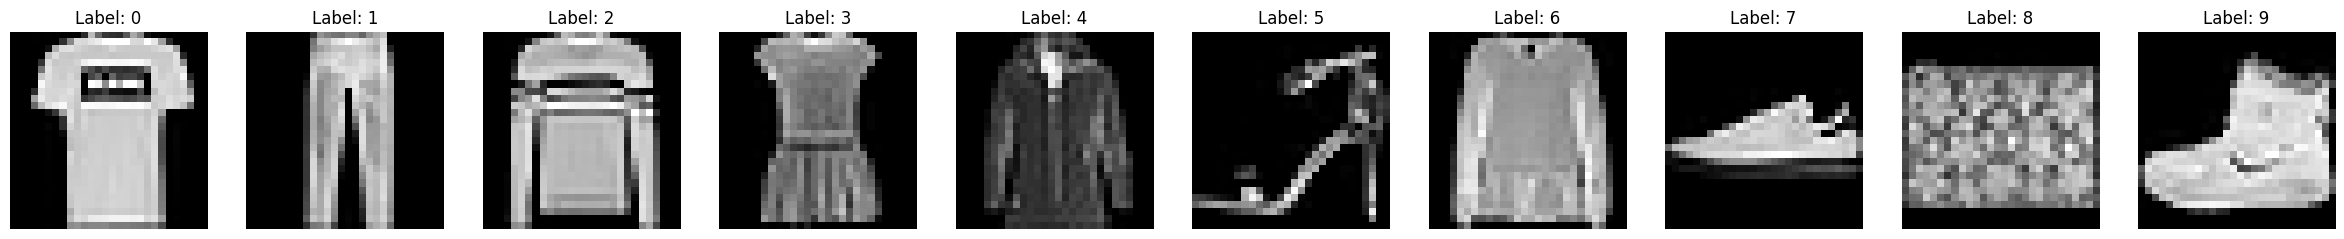

In [ ]:
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 10, figsize=(30, 12))
pil = ToPILImage()
for i in range(10):
    idx = (train_dataset.targets == i).nonzero()[0]
    image = pil(train_dataset.data[idx])
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {i}")
    axes[i].axis('off')
plt.show()


In [ ]:
import torch
import numpy as np

full_train_x, full_train_y = train_dataset.data, train_dataset.targets
full_test_x, full_test_y = test_dataset.data, test_dataset.targets

train_x = full_train_x.float().unsqueeze(1) / 255.0
test_x = full_test_x.float().unsqueeze(1) / 255.0

print(f'Size of train_x: {train_x.shape}')
print(f'Size of test_x: {test_x.shape}')


Size of train_x: torch.Size([60000, 1, 28, 28])
Size of test_x: torch.Size([10000, 1, 28, 28])


In [ ]:
import PIL.ImageOps
import torch.nn as nn
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_of_blocks, stride_conv, stride_pool, kernel_conv_size, kernel_pool_size, out_channels=6, in_channels=1, block_type='a'):
        super(CNN, self).__init__()
        layers = []
        self.in_channels_original = in_channels

        for _ in range(num_of_blocks):
            if block_type == 'a':
                layers.extend([
                    nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_pool_size, stride=stride_pool)
                ])
            elif block_type == 'b':
                layers.extend([
                    nn.Conv2d(in_channels, out_channels, kernel_conv_size, stride=stride_conv),
                    nn.ReLU(),
                    nn.Conv2d(out_channels, out_channels, kernel_conv_size, stride=stride_conv),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_pool_size, stride=stride_pool)
                ])
            in_channels = out_channels

        layers.append(nn.Flatten())

        self.model = nn.Sequential(*layers)

        with torch.no_grad():
            sample_input = torch.zeros(1, self.in_channels_original, 28, 28)
            sample_output = self.model(sample_input)
            linear_input_dim = sample_output.shape[1]

        self.fc = nn.Sequential(
            nn.Linear(linear_input_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        return x

    def fit(self, X, Y, epochs, lr, batch_size=100, logs=True):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        for epoch in range(epochs):
            indices = np.random.permutation(X.shape[0])
            X, Y = X[indices], Y[indices]
            for i in range(X.shape[0] // batch_size):
                x, y = X[i * batch_size:(i + 1) * batch_size], Y[i * batch_size:(i + 1) * batch_size]
                optimizer.zero_grad()
                pred = self(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
            if logs:
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    def predict(self, X):
        with torch.no_grad():
            return self(X).argmax(dim=1)

In [ ]:

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def draw_confusion_matrix(y_pred, y_true):
    with torch.no_grad():
        matrix = confusion_matrix(y_true, y_pred)
        ConfusionMatrixDisplay(matrix, display_labels=range(10)).plot(include_values=True, cmap='Blues')

In [ ]:
block_types = ['a', 'b']
num_blocks_options = [1, 2]
best_accuracy = 0

for block_type in block_types:
    for num_blocks in num_blocks_options:
        model = CNN(num_of_blocks=num_blocks, stride_conv=1, stride_pool=2, kernel_conv_size=5, kernel_pool_size=2, out_channels=6, in_channels=1, block_type=block_type)
        model.fit(train_x, full_train_y, epochs=10, lr=0.1, batch_size=32)

        with torch.no_grad():
            pred = model.predict(test_x).numpy()
            test_y_labels = full_test_y.numpy()
            acc = accuracy_score(test_y_labels, pred)
            print(f'Block: {block_type}, Blocks num: {num_blocks}, Accuracy: {acc}')

            if acc > best_accuracy:
                best_accuracy = acc
                best_block_type = block_type
                best_num_blocks = num_blocks

print(f'Best block type: {best_block_type}, Best num of blocks: {best_num_blocks}, Accuracy: {best_accuracy}')


Epoch 1/10, Loss: 0.40352264046669006
Epoch 2/10, Loss: 0.19854576885700226
Epoch 3/10, Loss: 0.20691409707069397
Epoch 4/10, Loss: 0.5572512745857239
Epoch 5/10, Loss: 0.26277223229408264
Epoch 6/10, Loss: 0.5412675738334656
Epoch 7/10, Loss: 0.11326968669891357
Epoch 8/10, Loss: 0.007316804490983486
Epoch 9/10, Loss: 0.31674885749816895
Epoch 10/10, Loss: 0.2549314498901367
Block: a, Blocks num: 1, Accuracy: 0.8899
Epoch 1/10, Loss: 0.7326769232749939
Epoch 2/10, Loss: 0.6121594905853271
Epoch 3/10, Loss: 0.2836533486843109
Epoch 4/10, Loss: 0.25015729665756226
Epoch 5/10, Loss: 0.15257441997528076
Epoch 6/10, Loss: 0.44042083621025085
Epoch 7/10, Loss: 0.14707571268081665
Epoch 8/10, Loss: 0.6554922461509705
Epoch 9/10, Loss: 0.19272522628307343
Epoch 10/10, Loss: 0.540468156337738
Block: a, Blocks num: 2, Accuracy: 0.8767
Epoch 1/10, Loss: 0.44501993060112
Epoch 2/10, Loss: 0.2575850784778595
Epoch 3/10, Loss: 0.247841015458107
Epoch 4/10, Loss: 0.1584572196006775
Epoch 5/10, Loss:

Epoch 1/10, Loss: 0.813457190990448
Epoch 2/10, Loss: 0.4121474623680115
Epoch 3/10, Loss: 0.3946715295314789
Epoch 4/10, Loss: 0.4878295063972473
Epoch 5/10, Loss: 0.3877696394920349
Epoch 6/10, Loss: 0.27867570519447327
Epoch 7/10, Loss: 0.3298957347869873
Epoch 8/10, Loss: 0.24607956409454346
Epoch 9/10, Loss: 0.10891127586364746
Epoch 10/10, Loss: 0.23919785022735596
Accuracy with learning rate 0.3: 0.8908
Epoch 1/10, Loss: 0.5327279567718506
Epoch 2/10, Loss: 0.46504467725753784
Epoch 3/10, Loss: 0.08730044215917587
Epoch 4/10, Loss: 0.5461925268173218
Epoch 5/10, Loss: 0.19347219169139862
Epoch 6/10, Loss: 0.2198353260755539
Epoch 7/10, Loss: 0.07302449643611908
Epoch 8/10, Loss: 0.21445274353027344
Epoch 9/10, Loss: 0.2697821259498596
Epoch 10/10, Loss: 0.21836455166339874
Accuracy with learning rate 0.1: 0.8942
Epoch 1/10, Loss: 0.803214430809021
Epoch 2/10, Loss: 0.4374935030937195
Epoch 3/10, Loss: 0.34467118978500366
Epoch 4/10, Loss: 0.31219321489334106
Epoch 5/10, Loss: 0.

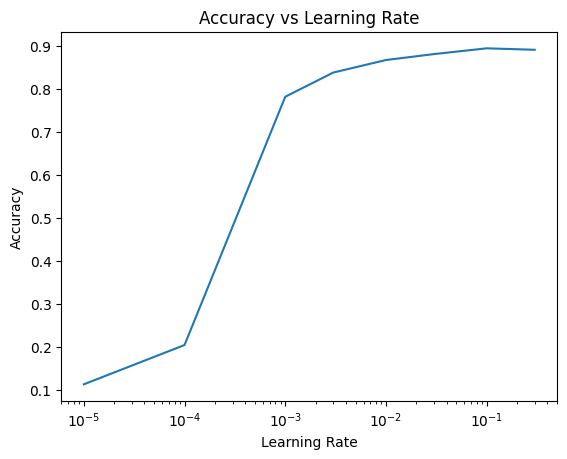

In [ ]:
lrs = [0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0001, 0.00001]
accuracy_scores = []

for lr in lrs:
    model = CNN(num_of_blocks=best_num_blocks, stride_conv=1, stride_pool=2, kernel_conv_size=5, kernel_pool_size=2, out_channels=6, in_channels=1, block_type=best_block_type)
    model.fit(train_x, full_train_y, epochs=10, lr=lr, batch_size=32)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = full_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with learning rate {lr}: {accuracy}')

max_lr = lrs[accuracy_scores.index(max(accuracy_scores))]
print(f'Best learning rate: {max_lr}')

plt.plot(lrs, accuracy_scores)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.show()

Epoch 1/10, Loss: 0.17612332105636597
Epoch 2/10, Loss: 0.289866179227829
Epoch 3/10, Loss: 0.08731330186128616
Epoch 4/10, Loss: 0.041179362684488297
Epoch 5/10, Loss: 0.13088470697402954
Epoch 6/10, Loss: 0.2984779477119446
Epoch 7/10, Loss: 0.3979751467704773
Epoch 8/10, Loss: 0.013351734727621078
Epoch 9/10, Loss: 0.33810609579086304
Epoch 10/10, Loss: 0.15192477405071259
Accuracy with batch size 16: 0.8943
Epoch 1/10, Loss: 0.21984411776065826
Epoch 2/10, Loss: 0.3778066635131836
Epoch 3/10, Loss: 0.17226707935333252
Epoch 4/10, Loss: 0.12114261090755463
Epoch 5/10, Loss: 0.12135779857635498
Epoch 6/10, Loss: 0.21118934452533722
Epoch 7/10, Loss: 0.12413827329874039
Epoch 8/10, Loss: 0.2158755362033844
Epoch 9/10, Loss: 0.1845242828130722
Epoch 10/10, Loss: 0.20389734208583832
Accuracy with batch size 32: 0.8975
Epoch 1/10, Loss: 0.37383463978767395
Epoch 2/10, Loss: 0.27172577381134033
Epoch 3/10, Loss: 0.30041229724884033
Epoch 4/10, Loss: 0.3201178014278412
Epoch 5/10, Loss: 0.

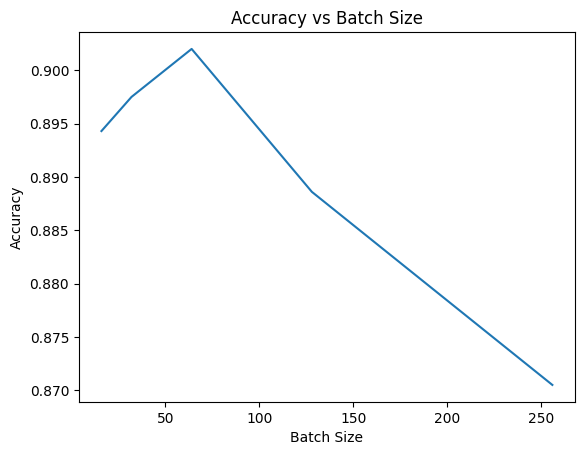

In [ ]:
batch_sizes = [16, 32, 64, 128, 256]
accuracy_scores = []

for batch_size in batch_sizes:
    model = CNN(num_of_blocks=best_num_blocks, stride_conv=1, stride_pool=2, kernel_conv_size=5, kernel_pool_size=2, out_channels=6, in_channels=1, block_type=best_block_type)
    model.fit(train_x, full_train_y, epochs=10, lr=max_lr, batch_size=batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = full_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with batch size {batch_size}: {accuracy}')

max_batch_size = batch_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best batch size: {max_batch_size}')

plt.plot(batch_sizes, accuracy_scores)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.show()

Epoch 1/10, Loss: 0.5584415197372437
Epoch 2/10, Loss: 0.45608454942703247
Epoch 3/10, Loss: 0.3246798813343048
Epoch 4/10, Loss: 0.2560037076473236
Epoch 5/10, Loss: 0.18091371655464172
Epoch 6/10, Loss: 0.3201616704463959
Epoch 7/10, Loss: 0.22064059972763062
Epoch 8/10, Loss: 0.281027615070343
Epoch 9/10, Loss: 0.2618332803249359
Epoch 10/10, Loss: 0.438935250043869
Accuracy with convolution kernel size 3: 0.8909
Epoch 1/10, Loss: 0.4822561740875244
Epoch 2/10, Loss: 0.304450660943985
Epoch 3/10, Loss: 0.3561847507953644
Epoch 4/10, Loss: 0.3758443295955658
Epoch 5/10, Loss: 0.22886323928833008
Epoch 6/10, Loss: 0.28287845849990845
Epoch 7/10, Loss: 0.48455801606178284
Epoch 8/10, Loss: 0.27149754762649536
Epoch 9/10, Loss: 0.3225102722644806
Epoch 10/10, Loss: 0.16264832019805908
Accuracy with convolution kernel size 5: 0.8853
Epoch 1/10, Loss: 0.5156433582305908
Epoch 2/10, Loss: 0.4131604731082916
Epoch 3/10, Loss: 0.29871127009391785
Epoch 4/10, Loss: 0.2473401576280594
Epoch 5/

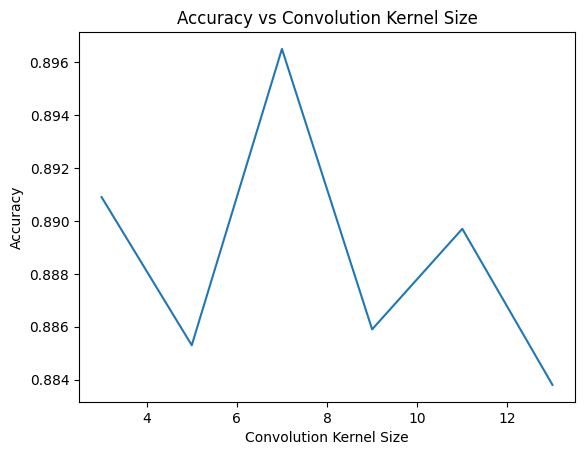

In [ ]:
conv_kernel_sizes = [3, 5, 7, 9, 11, 13]
accuracy_scores = []

for conv_kernel_size in conv_kernel_sizes:
    model = CNN(num_of_blocks=best_num_blocks, stride_conv=1, stride_pool=2, kernel_conv_size=conv_kernel_size, kernel_pool_size=2, out_channels=6, in_channels=1, block_type=best_block_type)
    model.fit(train_x, full_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = full_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution kernel size {conv_kernel_size}: {accuracy}')

max_conv_kernel_size = conv_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution kernel size: {max_conv_kernel_size}')

plt.plot(conv_kernel_sizes, accuracy_scores)
plt.xlabel('Convolution Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Kernel Size')
plt.show()

Epoch 1/10, Loss: 0.5552265644073486
Epoch 2/10, Loss: 0.40095359086990356
Epoch 3/10, Loss: 0.5811821818351746
Epoch 4/10, Loss: 0.20551055669784546
Epoch 5/10, Loss: 0.3417155146598816
Epoch 6/10, Loss: 0.22179682552814484
Epoch 7/10, Loss: 0.1592886596918106
Epoch 8/10, Loss: 0.16128742694854736
Epoch 9/10, Loss: 0.3189395070075989
Epoch 10/10, Loss: 0.20669735968112946
Accuracy with convolution stride 1: 0.8858
Epoch 1/10, Loss: 0.3990902900695801
Epoch 2/10, Loss: 0.4574166238307953
Epoch 3/10, Loss: 0.4553508460521698
Epoch 4/10, Loss: 0.38912028074264526
Epoch 5/10, Loss: 0.306375116109848
Epoch 6/10, Loss: 0.5100336670875549
Epoch 7/10, Loss: 0.19622433185577393
Epoch 8/10, Loss: 0.3674222528934479
Epoch 9/10, Loss: 0.2856829762458801
Epoch 10/10, Loss: 0.5164834856987
Accuracy with convolution stride 2: 0.8688
Epoch 1/10, Loss: 0.5540683269500732
Epoch 2/10, Loss: 0.49376437067985535
Epoch 3/10, Loss: 0.3240754008293152
Epoch 4/10, Loss: 0.44439077377319336
Epoch 5/10, Loss: 0

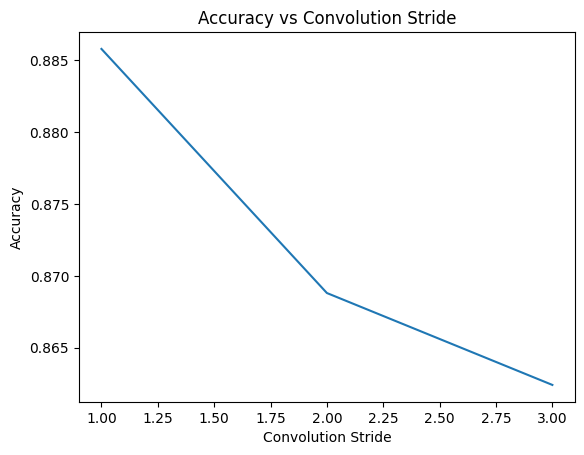

In [ ]:
conv_strides = [1, 2, 3]
accuracy_scores = []

for conv_stride in conv_strides:
    model = CNN(num_of_blocks=best_num_blocks, stride_conv=conv_stride, stride_pool=2, kernel_conv_size=max_conv_kernel_size, kernel_pool_size=2, out_channels=6, in_channels=1, block_type=best_block_type)
    model.fit(train_x, full_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = full_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with convolution stride {conv_stride}: {accuracy}')

max_conv_stride = conv_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best convolution stride: {max_conv_stride}')

plt.plot(conv_strides, accuracy_scores)
plt.xlabel('Convolution Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Convolution Stride')
plt.show()

Epoch 1/10, Loss: 0.4170738160610199
Epoch 2/10, Loss: 0.41697806119918823
Epoch 3/10, Loss: 0.4657648205757141
Epoch 4/10, Loss: 0.46712934970855713
Epoch 5/10, Loss: 0.4431052505970001
Epoch 6/10, Loss: 0.25050482153892517
Epoch 7/10, Loss: 0.16793309152126312
Epoch 8/10, Loss: 0.19000618159770966
Epoch 9/10, Loss: 0.20929084718227386
Epoch 10/10, Loss: 0.4016987383365631
Accuracy with pool kernel size 2: 0.8919
Epoch 1/10, Loss: 0.5264068245887756
Epoch 2/10, Loss: 0.5388815402984619
Epoch 3/10, Loss: 0.1644463837146759
Epoch 4/10, Loss: 0.40073323249816895
Epoch 5/10, Loss: 0.4079109728336334
Epoch 6/10, Loss: 0.19771526753902435
Epoch 7/10, Loss: 0.27272829413414
Epoch 8/10, Loss: 0.3568948805332184
Epoch 9/10, Loss: 0.1660827398300171
Epoch 10/10, Loss: 0.16811388731002808
Accuracy with pool kernel size 3: 0.8918
Epoch 1/10, Loss: 0.5521346926689148
Epoch 2/10, Loss: 0.342430055141449
Epoch 3/10, Loss: 0.2680569589138031
Epoch 4/10, Loss: 0.3557190001010895
Epoch 5/10, Loss: 0.24

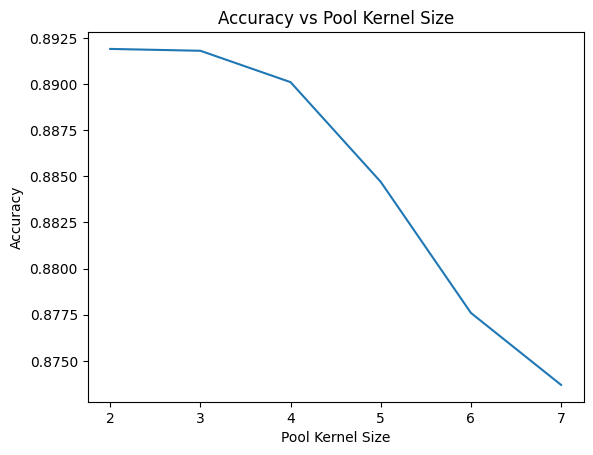

In [ ]:
pool_kernel_sizes = [2, 3, 4, 5, 6, 7]
accuracy_scores = []

for pool_kernel_size in pool_kernel_sizes:
    model = CNN(num_of_blocks=best_num_blocks, stride_conv=max_conv_stride, stride_pool=2, kernel_conv_size=max_conv_kernel_size, kernel_pool_size=pool_kernel_size, out_channels=6, in_channels=1, block_type=best_block_type)
    model.fit(train_x, full_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = full_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool kernel size {pool_kernel_size}: {accuracy}')

max_pool_kernel_size = pool_kernel_sizes[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool kernel size: {max_pool_kernel_size}')

plt.plot(pool_kernel_sizes, accuracy_scores)
plt.xlabel('Pool Kernel Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Kernel Size')
plt.show()

Epoch 1/10, Loss: 0.5289065837860107
Epoch 2/10, Loss: 0.20006568729877472
Epoch 3/10, Loss: 0.2230287492275238
Epoch 4/10, Loss: 0.24889005720615387
Epoch 5/10, Loss: 0.24364301562309265
Epoch 6/10, Loss: 0.18284057080745697
Epoch 7/10, Loss: 0.10993332415819168
Epoch 8/10, Loss: 0.24630697071552277
Epoch 9/10, Loss: 0.16364571452140808
Epoch 10/10, Loss: 0.34721675515174866
Accuracy with pool stride 1: 0.88
Epoch 1/10, Loss: 0.7018989324569702
Epoch 2/10, Loss: 0.2735545039176941
Epoch 3/10, Loss: 0.28651681542396545
Epoch 4/10, Loss: 0.3194868266582489
Epoch 5/10, Loss: 0.296230286359787
Epoch 6/10, Loss: 0.23502816259860992
Epoch 7/10, Loss: 0.21535970270633698
Epoch 8/10, Loss: 0.27597951889038086
Epoch 9/10, Loss: 0.3319550156593323
Epoch 10/10, Loss: 0.14934036135673523
Accuracy with pool stride 2: 0.8938
Epoch 1/10, Loss: 0.7094475626945496
Epoch 2/10, Loss: 0.6521270275115967
Epoch 3/10, Loss: 0.2927893400192261
Epoch 4/10, Loss: 0.45367056131362915
Epoch 5/10, Loss: 0.4320078

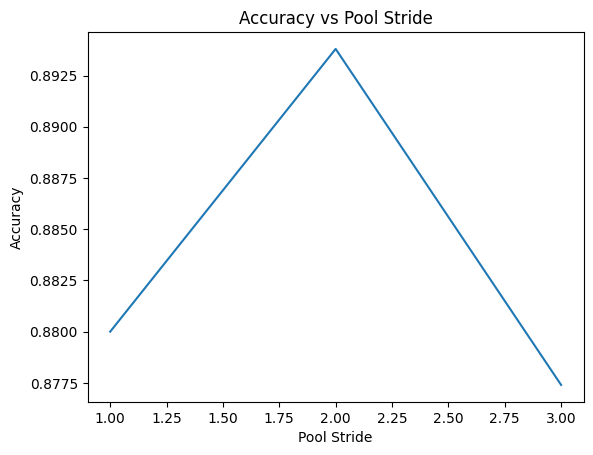

In [ ]:
pool_strides = [1, 2, 3]
accuracy_scores = []

for pool_stride in pool_strides:
    model = CNN(num_of_blocks=best_num_blocks, stride_conv=max_conv_stride, stride_pool=pool_stride, kernel_conv_size=max_conv_kernel_size, kernel_pool_size=max_pool_kernel_size, out_channels=6, in_channels=1, block_type=best_block_type)
    model.fit(train_x, full_train_y, epochs=10, lr=max_lr, batch_size=max_batch_size)
    with torch.no_grad():
        pred = model.predict(test_x).numpy()
        test_y_labels = full_test_y.numpy()

        accuracy = accuracy_score(test_y_labels, pred)
        accuracy_scores.append(accuracy)
        print(f'Accuracy with pool stride {pool_stride}: {accuracy}')

max_pool_stride = pool_strides[accuracy_scores.index(max(accuracy_scores))]
print(f'Best pool stride: {max_pool_stride}')

plt.plot(pool_strides, accuracy_scores)
plt.xlabel('Pool Stride')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Pool Stride')
plt.show()

blocks_num=1, conv_stride=1, pool_stride=2, conv_kernel_size=7, pool_kernel_size=2, block_type = a
Epoch: 1
Epoch 1/10, Loss: 0.4717043936252594
Epoch 2/10, Loss: 0.38199615478515625
Epoch 3/10, Loss: 0.2288050353527069
Epoch 4/10, Loss: 0.20472662150859833
Epoch 5/10, Loss: 0.31490421295166016
Epoch 6/10, Loss: 0.4307268261909485
Epoch 7/10, Loss: 0.25949421525001526
Epoch 8/10, Loss: 0.2264997959136963
Epoch 9/10, Loss: 0.19021479785442352
Epoch 10/10, Loss: 0.2958727777004242
Accuracy: 0.8963
Epoch: 2
Epoch 1/10, Loss: 0.11789403855800629
Epoch 2/10, Loss: 0.20631909370422363
Epoch 3/10, Loss: 0.23627692461013794
Epoch 4/10, Loss: 0.1800270974636078
Epoch 5/10, Loss: 0.07013445347547531
Epoch 6/10, Loss: 0.10012417286634445
Epoch 7/10, Loss: 0.13660773634910583
Epoch 8/10, Loss: 0.07135581225156784
Epoch 9/10, Loss: 0.1660822331905365
Epoch 10/10, Loss: 0.12934650480747223
Accuracy: 0.9025


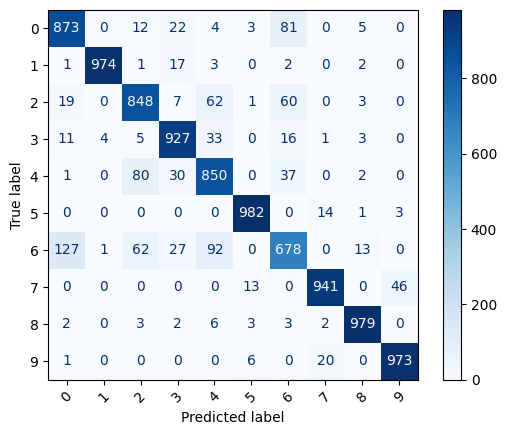

In [ ]:
print(f'blocks_num={best_num_blocks}, conv_stride={max_conv_stride}, pool_stride={max_pool_stride}, conv_kernel_size={max_conv_kernel_size}, pool_kernel_size={max_pool_kernel_size}, block_type = {best_block_type}')
model = CNN(
    num_of_blocks=best_num_blocks,
    stride_conv=max_conv_stride,
    stride_pool=max_pool_stride,
    kernel_conv_size=max_conv_kernel_size,
    kernel_pool_size=max_pool_kernel_size,
    block_type=best_block_type
)

for i in range(10):
    print(f'Epoch: {i+1}')
    model.fit(train_x, full_train_y, 10, max_lr, max_batch_size)
    pred = model.predict(test_x).numpy()
    test_y_labels = full_test_y.numpy()
    accuracy = accuracy_score(test_y_labels, pred)
    print(f'Accuracy: {accuracy}')

    if accuracy > 0.9:
      break

with torch.no_grad():
    pred = model.predict(test_x).numpy()
    draw_confusion_matrix(pred, full_test_y.numpy())